# Spatial summer sea ice fluctuations
## Rolling time windows

(the proper version)

In [1]:
import numpy as np
import numpy as np
import xarray as xr
import flucutations_functions as ffu

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,4) #(10,6)
plt.rcParams['figure.dpi'] = 100 #300
plt.rcParams['savefig.dpi'] = 200 #600
from matplotlib.pyplot import cm
import matplotlib.ticker as tck

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import seaborn as sns
sns.set()
sns.set_style("whitegrid")

/tmp/ipykernel_24081/3739567442.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [3]:
# range of years
years = range(1979,2022)

### September SI border points in 1.5 degree gridding:

In [4]:
cen_bo_coarse= xr.open_dataset("centers_borders_1_5_sat_every.nc")
centers_c = cen_bo_coarse.center.data
borders_c = cen_bo_coarse.border.data

npoints_c = borders_c.shape[2]

#calc distance to center: 
dists_c_c = ffu.dists_to_c(borders_c,centers_c,len(years),borders_c.shape[2])


### September SI border points in 0.5 degree dridding:

In [5]:
cen_bo_fine = xr.open_dataset("centers_borders_0_5_sat_every_centerN.nc")
centers_f = cen_bo_fine.center.data
borders_f = cen_bo_fine.border.data

npoints_f = borders_f.shape[2]

#calc distance to center: 
dists_c_f = ffu.dists_to_c(borders_f,centers_f,len(years),borders_f.shape[2])

### Detrending:
#### Linear fit to each time segment

**Note: for now, try another fit over the whole time period**

Maybe sth like a Gaussian kernel?!

In [6]:
def detrend(dist):
    detrendeds = np.zeros_like(dist)
    for i,ts in enumerate(dist):
        y=ts
        N = y.shape[0]
        x = range(N)
        beta = np.polyfit(x,y,1)
        linear_fit = beta[1] + beta[0]*x
        detrended = y - linear_fit
        detrendeds[i] = detrended
    return detrendeds

In [7]:
geo_dists_coarse = ffu.calc_geo_dists(borders_c)
geo_dists_fine = ffu.calc_geo_dists(borders_f)

In [8]:
def calc_scale_window(center_dist, geo_dist, 
                window_size = 13, to_center = True, 
                binning_step = 50, geo_where = "midpoint", 
                n_shuffles_geo_cov = 100, n_shuffles_scale = 100,
                fit_until = 1000):
    """calculates the spatial scales and their standard deviation
         for sliding window of a certain window size"""
    
    #create xarray of distance to center
    x_center_dist= xr.DataArray(center_dist,
        coords = [years, range(center_dist.shape[1])],
        dims = ["time", "points"])
    #create rolling window
    center_dist_rolled = x_center_dist.rolling(
                    time =window_size, center = to_center, min_periods =None).construct(
                        window_dim = "wd", stride = 1)
    
    #create xarray of geo distance between points
    x_geo_dist = xr.DataArray(geo_dist,
    coords = [years, range(geo_dist.shape[1]), range(geo_dist.shape[2])],
    dims = ["time", "x", "y"])
    #create rolling window
    geo_dist_rolled = x_geo_dist.rolling(
                time =window_size, center = to_center, min_periods =None).construct(
                    window_dim = "wd", stride = 1)

    #create empty lists with None values for the first years, where there are Nones (not enough data)
    spatial_scales = [np.nan for k in range(int(window_size/2))]
    std_spatial_scales = [np.nan for k in range(int(window_size/2))]

    #calculate the spatial scale for every window (where no Nan values in the distance arrays)
    for k in range(int(window_size/2),len(years)-int(window_size/2)):
        dist_c = center_dist_rolled.isel(time=k).data
        detrended_dists = detrend(dist_c)
        cov = np.cov(detrended_dists, bias = True)
        shifted_rows = ffu.calc_shifted_rows(cov)
        mean_row = np.mean(shifted_rows, axis = 0)
        geo_dists = geo_dist_rolled.isel(time = k).data
        shifted_geo_dists = ffu.calc_shifted_rows(np.mean(geo_dists, axis=2))
        binned_geo, binned_cov = ffu.binning_geo_cov(shifted_geo_dists, shifted_rows, 
                    stepsize=binning_step, geo_to = geo_where)
        
        err_geo_cov = ffu.get_errorbars_geo_cov(shifted_geo_dists, detrended_dists, 
                    n_shuffles = n_shuffles_geo_cov, bin_steps = binning_step, geo_set_to = geo_where)
        s,std_scale = ffu.get_spatial_scale(binned_geo, binned_cov,err_geo_cov, 
                    until = fit_until, n_scale_shuffles = n_shuffles_scale, get_fit = False)
        spatial_scales.append(s)
        std_spatial_scales.append(std_scale)
    spatial_scales.extend([np.nan for k in range(int(window_size/2))])
    std_spatial_scales.extend([np.nan for k in range(int(window_size/2))])
    return np.array(spatial_scales), np.array(std_spatial_scales)

define a class, so that the windows and griddings are easier to handle:

In [9]:
class scale:
    def __init__(self, gridding, w, s, std_s):
        self.gridding = gridding
        self.window = w
        self.scale = s
        self.std_scale = std_s

Calculate the spatial scales for sliding time windows of different sizes (with linear detrending in each window) as well as their std. Save as netcdf, because it takes a while to calculate..

In [10]:
scales_list = []

for w in range(7,25,2):
    print(f"w={w}:")
    
    #coarse
    filename_coarse ="scales_{}_deg_windowsize_{}.nc".format(1.5,w)
    if os.path.exists(filename_coarse):
        print("coarse: open existing data")
        ds_c = xr.open_dataset(filename_coarse)
        s_c = scale(1.5, w, ds_c.scale.data, ds_c.std_scale.data)
        scales_list.append(s_c)
    else: 
        print("coarse: create the dataset")
        scales_c, errors_c = calc_scale_window(dists_c_c, geo_dists_coarse, 
                    window_size = w, to_center = True, 
                    binning_step = 50, geo_where = "midpoint", 
                    n_shuffles_geo_cov = 100, n_shuffles_scale = 100,
                    fit_until = 1000)
        s_c = scale(1.5, w, scales_c, errors_c)
        scales_list.append(s_c)
        
        ds_c = xr.Dataset(
                {"scale": (("time"), scales_c),
                "std_scale":(("time"), errors_c)},
                coords = {"time":years}
        )
        ds_c.to_netcdf(filename_coarse)

    #fine
    filename_fine ="scales_{}_deg_windowsize_{}.nc".format(0.5,w)
    if os.path.exists(filename_fine):
        print("fine: open existing data")
        ds_f = xr.open_dataset(filename_fine)
        s_f = scale(0.5, w, ds_f.scale.data, ds_f.std_scale.data)
        scales_list.append(s_f)
    else: 
        print("fine: create the dataset")
        scales_f, errors_f = calc_scale_window(dists_c_f, geo_dists_fine, 
                    window_size = w, to_center = True, 
                    binning_step = 50, geo_where = "midpoint", 
                    n_shuffles_geo_cov = 100, n_shuffles_scale = 100,
                    fit_until = 1000)
        s_f = scale(0.5, w, scales_f, errors_f)
        scales_list.append(s_f)
        
        ds_f = xr.Dataset(
                {"scale": (("time"), scales_f),
                "std_scale":(("time"), errors_f)},
                coords = {"time":years}
        )
        ds_f.to_netcdf(filename_fine)

w=7:
coarse: open existing data
fine: open existing data
w=9:
coarse: open existing data
fine: open existing data
w=11:
coarse: open existing data
fine: open existing data
w=13:
coarse: open existing data
fine: open existing data
w=15:
coarse: open existing data
fine: open existing data
w=17:
coarse: open existing data
fine: open existing data
w=19:
coarse: open existing data
fine: open existing data
w=21:
coarse: open existing data
fine: open existing data
w=23:
coarse: open existing data
fine: open existing data


Plot:

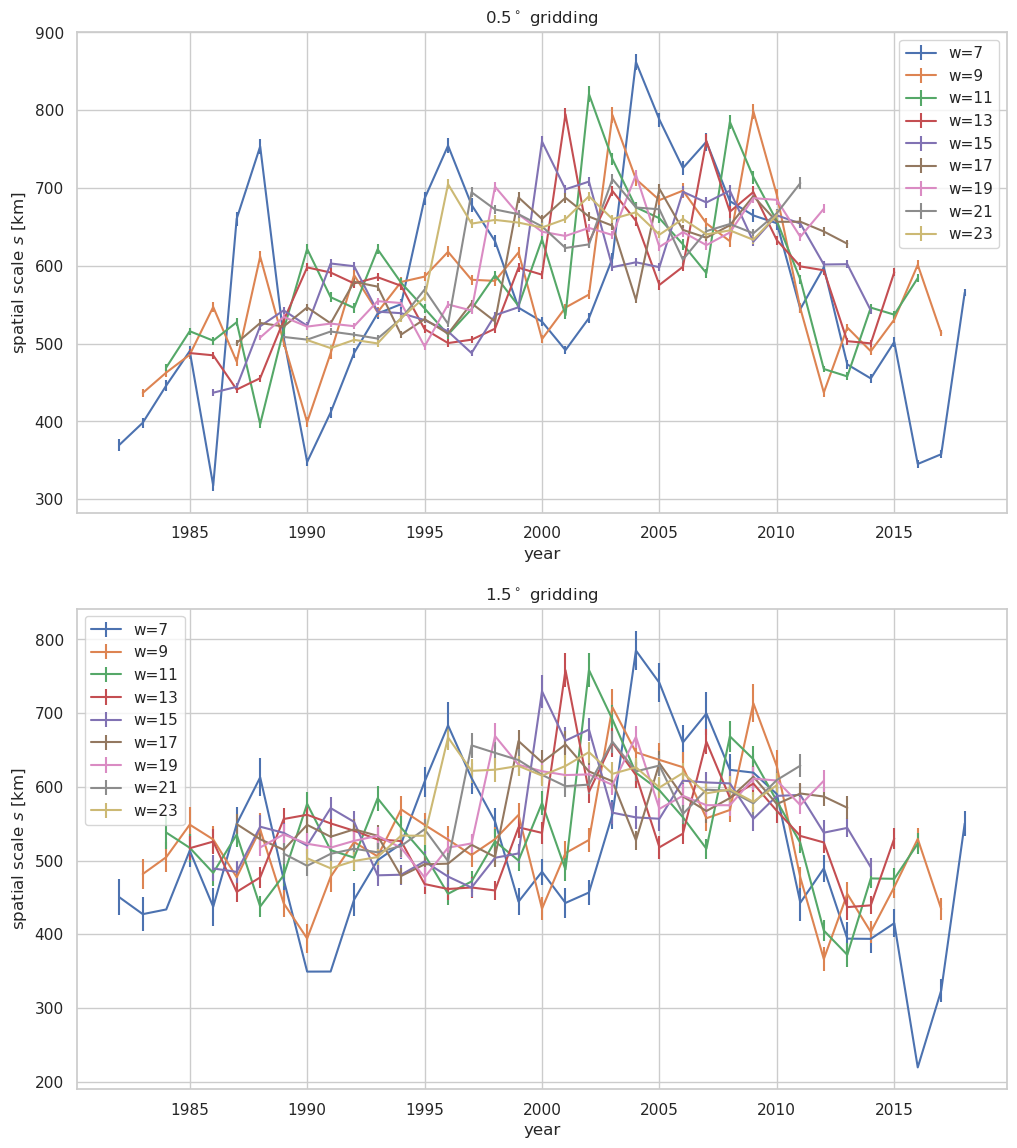

In [11]:
fig, axs = plt.subplots(2, figsize=(12,14))
for k, ts in enumerate(scales_list):
    if ts.window>=7:
        if ts.gridding == 0.5:
            axs[0].errorbar(years, ts.scale, yerr=ts.std_scale, label = "w={}".format(ts.window))
            #axs[0].scatter([years[np.nanargmax(ts.scale)]], [np.nanmax(ts.scale)])
            axs[0].set_title("0.5$^\circ$ gridding")
            axs[0].set_xlabel("year")
            axs[0].set_ylabel("spatial scale $s$ [km]")
            axs[0].legend()

        else:
            axs[1].errorbar(years, ts.scale, yerr=ts.std_scale, label = "w={}".format(ts.window))
            #axs[1].scatter([years[np.nanargmax(ts.scale)]], [np.nanmax(ts.scale)])
            axs[1].set_title("1.5$^\circ$ gridding")
            axs[1].set_xlabel("year")
            axs[1].set_ylabel("spatial scale $s$ [km]")
            axs[1].legend()
#plt.savefig("figures/scale_for_windows_per gridding")

Again, but with now each windowsize in a different pannel:

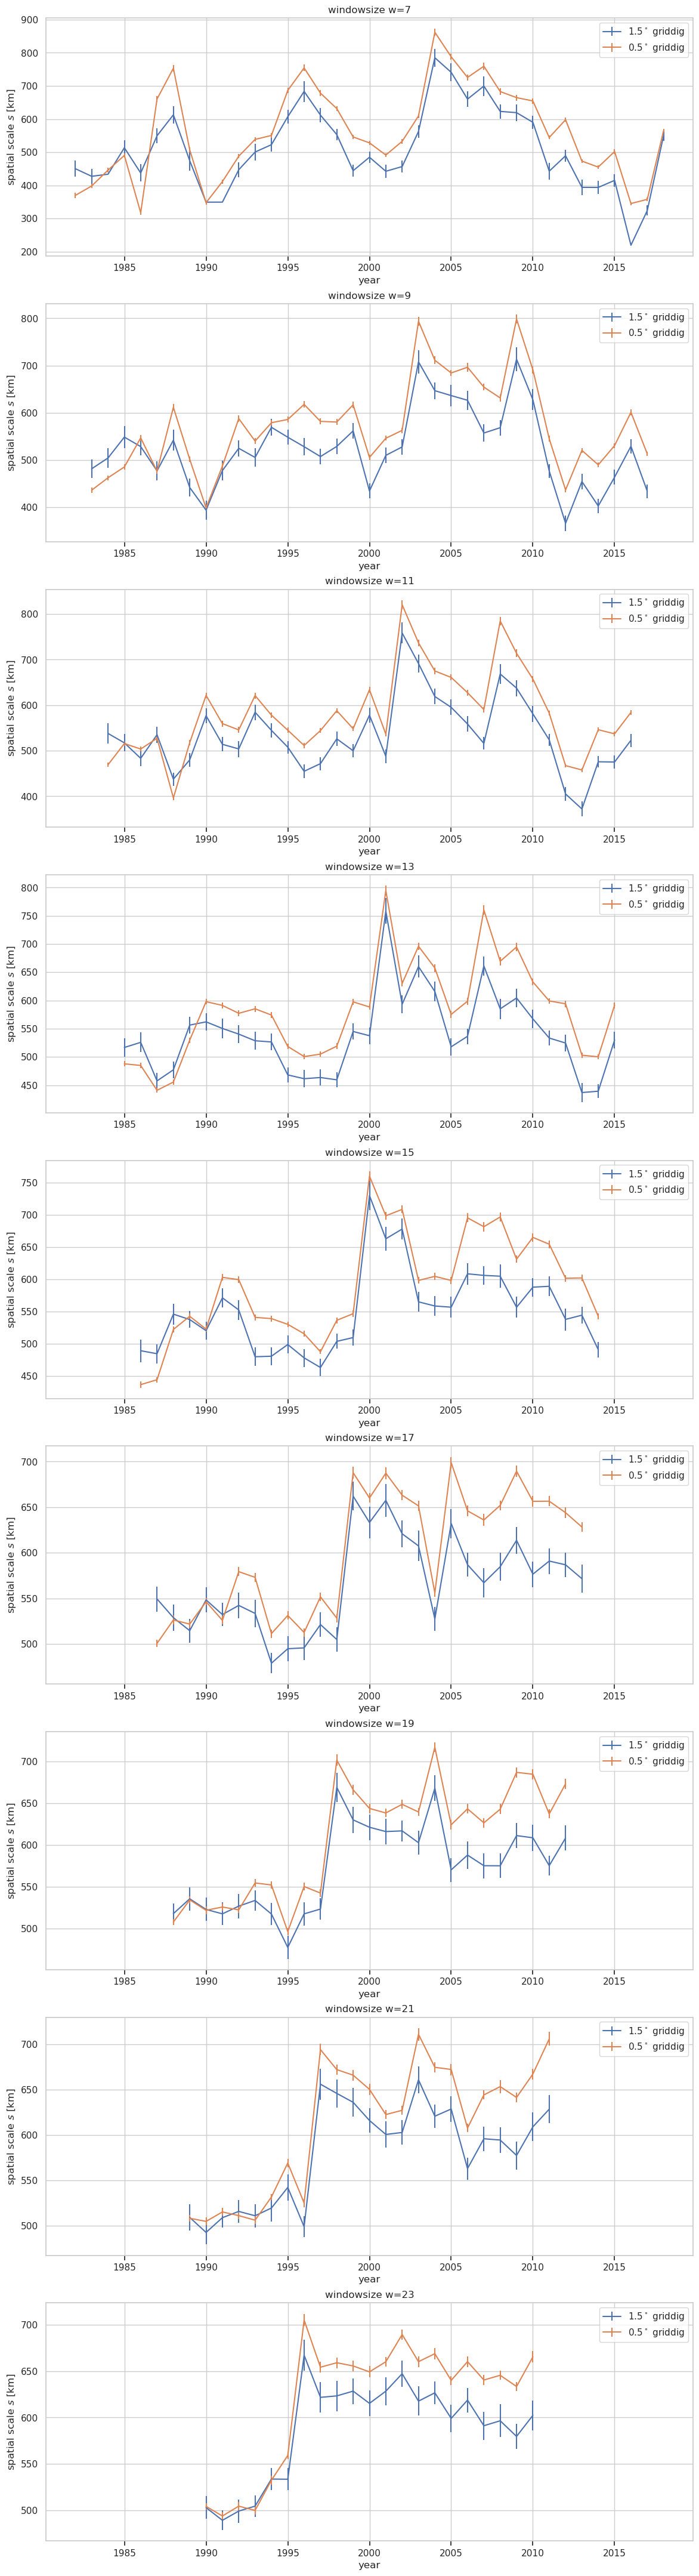

In [12]:
fig, axs = plt.subplots(int(len(scales_list)/2),1, figsize=(14,14*int(len(scales_list)/4)), sharex = "all")

for k, ts in enumerate(scales_list):
    if ts.window>=7:
        #if ts.gridding == 1.5:
            #axs[int(k/2)].set_xlabel("year")
            #axs[int(k/2)].set_ylabel("spatial scale")
            #axs[int(k/2)].legend()
            #axs[int(k/2)].tick_params(axis = "x", reset = True, top = False)

        axs[int(k/2)].errorbar(years, ts.scale, yerr=ts.std_scale, label = "{}$^\circ$ griddig".format(ts.gridding))
        axs[int(k/2)].set_title("windowsize w={}".format(ts.window))
        axs[int(k/2)].set_xlabel("year")
        axs[int(k/2)].set_ylabel("spatial scale $s$ [km]")
        axs[int(k/2)].legend()
        axs[int(k/2)].tick_params(axis = "x", reset = True, top = False)

#plt.savefig("figures/scale_for_windows_per_window")